# imports

In [1]:
import numpy as np
import torch as t
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import time
import copy
from collections import OrderedDict
from functools import partial
import math
from typing import List, Tuple, Optional
from itertools import repeat
# from torch._six import container_abcs
import pickle
import collections.abc as container_abcs 
import torch
from torch.hub import load_state_dict_from_url
!pip install dropblock
from dropblock import DropBlock2D
from dropblock import LinearScheduler as DropBlockScheduled

In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download -d jessicali9530/celeba-dataset

Saving kaggle.json to kaggle.json
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              233KB  2021-08-22 13:49:51          11098  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           6785  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           2618  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52           1691  
dhruvildave/wikibooks-dataset             

In [3]:
%%capture
! mkdir train
! unzip /content/celeba-dataset.zip -d train

# Choose Device

In [4]:
# choose device
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print("Device: {}".format(t.cuda.get_device_name(0)))
print("Device type: {}".format(device))

Device: Tesla T4
Device type: cuda


# Hyperparameters

In [5]:
batch_size = 64

random_seed = 42
np.random.seed(random_seed)
t.backends.cudnn.enabled = False
t.manual_seed(random_seed)

# Get Data and Dataloaders

In [6]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1., device='cpu'):
        self.std = std
        self.mean = mean
        self.device = device

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()).to(self.device) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [7]:
%%capture
# transform = transforms.Compose([transforms.ToTensor(),
#                                 transforms.Normalize((0.1307,), (0.3081,)),
#                                 transforms.Resize((64, 64))])
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                transforms.CenterCrop(178), 
                                transforms.Resize(32), 
                                transforms.RandomHorizontalFlip()])
dataset = datasets.ImageFolder(root='/content/train/img_align_celeba', transform=transform)

# testset = datasets.CelebA(root='./data', transform=transform, download=True, split='test')

# dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


In [8]:
train_inds, val_inds = train_test_split(t.arange(len(dataset)), test_size=0.2)

# get dataloaders
train_sampler = t.utils.data.SubsetRandomSampler(train_inds)
val_sampler = t.utils.data.SubsetRandomSampler(val_inds)

train_loader = t.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = t.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
# test_loader = t.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

# Architecture

In [9]:
def sigmoid(x, inplace: bool = False):
    return x.sigmoid_() if inplace else x.sigmoid()
    
""" Layer/Module Helpers
Hacked together by Ross Wightman
"""

# From PyTorch internals
def _ntuple(n):
    def parse(x):
        if isinstance(x, container_abcs.Iterable):
            return x
        return tuple(repeat(x, n))
    return parse


tup_single = _ntuple(1)
tup_pair = _ntuple(2)
tup_triple = _ntuple(3)
tup_quadruple = _ntuple(4)

In [10]:
""" Padding Helpers

Hacked together by Ross Wightman
"""

# import torch.nn.functional as F


# Calculate symmetric padding for a convolution
def get_padding(kernel_size: int, stride: int = 1, dilation: int = 1, **_) -> int:
    padding = ((stride - 1) + dilation * (kernel_size - 1)) // 2
    return padding


# Calculate asymmetric TensorFlow-like 'SAME' padding for a convolution
def get_same_padding(x: int, k: int, s: int, d: int):
    return max((math.ceil(x / s) - 1) * s + (k - 1) * d + 1 - x, 0)


# Can SAME padding for given args be done statically?
def is_static_pad(kernel_size: int, stride: int = 1, dilation: int = 1, **_):
    return stride == 1 and (dilation * (kernel_size - 1)) % 2 == 0


# Dynamically pad input x with 'SAME' padding for conv with specified args
def pad_same(x, k: List[int], s: List[int], d: List[int] = (1, 1), value: float = 0):
    ih, iw = x.size()[-2:]
    pad_h, pad_w = get_same_padding(ih, k[0], s[0], d[0]), get_same_padding(iw, k[1], s[1], d[1])
    if pad_h > 0 or pad_w > 0:
        x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2], value=value)
    return x


def get_padding_value(padding, kernel_size, **kwargs) -> Tuple[Tuple, bool]:
    dynamic = False
    if isinstance(padding, str):
        # for any string padding, the padding will be calculated for you, one of three ways
        padding = padding.lower()
        if padding == 'same':
            # TF compatible 'SAME' padding, has a performance and GPU memory allocation impact
            if is_static_pad(kernel_size, **kwargs):
                # static case, no extra overhead
                padding = get_padding(kernel_size, **kwargs)
            else:
                # dynamic 'SAME' padding, has runtime/GPU memory overhead
                padding = 0
                dynamic = True
        elif padding == 'valid':
            # 'VALID' padding, same as padding=0
            padding = 0
        else:
            # Default to PyTorch style 'same'-ish symmetric padding
            padding = get_padding(kernel_size, **kwargs)
    return padding, dynamic

In [11]:
""" Conv2d w/ Same Padding
Hacked together by Ross Wightman
"""


def conv2d_same(
        x, weight: torch.Tensor, bias: Optional[torch.Tensor] = None, stride: Tuple[int, int] = (1, 1),
        padding: Tuple[int, int] = (0, 0), dilation: Tuple[int, int] = (1, 1), groups: int = 1):
    x = pad_same(x, weight.shape[-2:], stride, dilation)
    return F.conv2d(x, weight, bias, stride, (0, 0), dilation, groups)


class Conv2dSame(nn.Conv2d):
    """ Tensorflow like 'SAME' convolution wrapper for 2D convolutions
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(Conv2dSame, self).__init__(
            in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)

    def forward(self, x):
        return conv2d_same(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


def create_conv2d_pad(in_chs, out_chs, kernel_size, **kwargs):
    padding = kwargs.pop('padding', '')
    kwargs.setdefault('bias', False)
    padding, is_dynamic = get_padding_value(padding, kernel_size, **kwargs)
    if is_dynamic:
        return Conv2dSame(in_chs, out_chs, kernel_size, **kwargs)
    else:
        return nn.Conv2d(in_chs, out_chs, kernel_size, padding=padding, **kwargs)

In [12]:
""" PyTorch Mixed Convolution

Paper: MixConv: Mixed Depthwise Convolutional Kernels (https://arxiv.org/abs/1907.09595)

Hacked together by Ross Wightman
"""

def _split_channels(num_chan, num_groups):
    split = [num_chan // num_groups for _ in range(num_groups)]
    split[0] += num_chan - sum(split)
    return split


class MixedConv2d(nn.ModuleDict):
    """ Mixed Grouped Convolution

    Based on MDConv and GroupedConv in MixNet impl:
      https://github.com/tensorflow/tpu/blob/master/models/official/mnasnet/mixnet/custom_layers.py
    """
    def __init__(self, in_channels, out_channels, kernel_size=3,
                 stride=1, padding='', dilation=1, depthwise=False, **kwargs):
        super(MixedConv2d, self).__init__()

        kernel_size = kernel_size if isinstance(kernel_size, list) else [kernel_size]
        num_groups = len(kernel_size)
        in_splits = _split_channels(in_channels, num_groups)
        out_splits = _split_channels(out_channels, num_groups)
        self.in_channels = sum(in_splits)
        self.out_channels = sum(out_splits)
        for idx, (k, in_ch, out_ch) in enumerate(zip(kernel_size, in_splits, out_splits)):
            conv_groups = out_ch if depthwise else 1
            # use add_module to keep key space clean
            self.add_module(
                str(idx),
                create_conv2d_pad(
                    in_ch, out_ch, k, stride=stride,
                    padding=padding, dilation=dilation, groups=conv_groups, **kwargs)
            )
        self.splits = in_splits

    def forward(self, x):
        x_split = torch.split(x, self.splits, 1)
        x_out = [c(x_split[i]) for i, c in enumerate(self.values())]
        x = torch.cat(x_out, 1)
        return x

In [13]:
""" PyTorch Conditionally Parameterized Convolution (CondConv)

Paper: CondConv: Conditionally Parameterized Convolutions for Efficient Inference
(https://arxiv.org/abs/1904.04971)

Hacked together by Ross Wightman
"""

def get_condconv_initializer(initializer, num_experts, expert_shape):
    def condconv_initializer(weight):
        """CondConv initializer function."""
        num_params = np.prod(expert_shape)
        if (len(weight.shape) != 2 or weight.shape[0] != num_experts or
                weight.shape[1] != num_params):
            raise (ValueError(
                'CondConv variables must have shape [num_experts, num_params]'))
        for i in range(num_experts):
            initializer(weight[i].view(expert_shape))
    return condconv_initializer


class CondConv2d(nn.Module):
    """ Conditionally Parameterized Convolution
    Inspired by: https://github.com/tensorflow/tpu/blob/master/models/official/efficientnet/condconv/condconv_layers.py

    Grouped convolution hackery for parallel execution of the per-sample kernel filters inspired by this discussion:
    https://github.com/pytorch/pytorch/issues/17983
    """
    __constants__ = ['in_channels', 'out_channels', 'dynamic_padding']

    def __init__(self, in_channels, out_channels, kernel_size=3,
                 stride=1, padding='', dilation=1, groups=1, bias=False, num_experts=4):
        super(CondConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = tup_pair(kernel_size)
        self.stride = tup_pair(stride)
        padding_val, is_padding_dynamic = get_padding_value(
            padding, kernel_size, stride=stride, dilation=dilation)
        self.dynamic_padding = is_padding_dynamic  # if in forward to work with torchscript
        self.padding = tup_pair(padding_val)
        self.dilation = tup_pair(dilation)
        self.groups = groups
        self.num_experts = num_experts

        self.weight_shape = (self.out_channels, self.in_channels // self.groups) + self.kernel_size
        weight_num_param = 1
        for wd in self.weight_shape:
            weight_num_param *= wd
        self.weight = torch.nn.Parameter(torch.Tensor(self.num_experts, weight_num_param))

        if bias:
            self.bias_shape = (self.out_channels,)
            self.bias = torch.nn.Parameter(torch.Tensor(self.num_experts, self.out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        init_weight = get_condconv_initializer(
            partial(nn.init.kaiming_uniform_, a=math.sqrt(5)), self.num_experts, self.weight_shape)
        init_weight(self.weight)
        if self.bias is not None:
            fan_in = np.prod(self.weight_shape[1:])
            bound = 1 / math.sqrt(fan_in)
            init_bias = get_condconv_initializer(
                partial(nn.init.uniform_, a=-bound, b=bound), self.num_experts, self.bias_shape)
            init_bias(self.bias)

    def forward(self, x, routing_weights):
        B, C, H, W = x.shape
        weight = torch.matmul(routing_weights, self.weight)
        new_weight_shape = (B * self.out_channels, self.in_channels // self.groups) + self.kernel_size
        weight = weight.view(new_weight_shape)
        bias = None
        if self.bias is not None:
            bias = torch.matmul(routing_weights, self.bias)
            bias = bias.view(B * self.out_channels)
        # move batch elements with channels so each batch element can be efficiently convolved with separate kernel
        x = x.view(1, B * C, H, W)
        if self.dynamic_padding:
            out = conv2d_same(
                x, weight, bias, stride=self.stride, padding=self.padding,
                dilation=self.dilation, groups=self.groups * B)
        else:
            out = F.conv2d(
                x, weight, bias, stride=self.stride, padding=self.padding,
                dilation=self.dilation, groups=self.groups * B)
        out = out.permute([1, 0, 2, 3]).view(B, self.out_channels, out.shape[-2], out.shape[-1])

        # Literal port (from TF definition)
        # x = torch.split(x, 1, 0)
        # weight = torch.split(weight, 1, 0)
        # if self.bias is not None:
        #     bias = torch.matmul(routing_weights, self.bias)
        #     bias = torch.split(bias, 1, 0)
        # else:
        #     bias = [None] * B
        # out = []
        # for xi, wi, bi in zip(x, weight, bias):
        #     wi = wi.view(*self.weight_shape)
        #     if bi is not None:
        #         bi = bi.view(*self.bias_shape)
        #     out.append(self.conv_fn(
        #         xi, wi, bi, stride=self.stride, padding=self.padding,
        #         dilation=self.dilation, groups=self.groups))
        # out = torch.cat(out, 0)
        return out

In [14]:
""" Create Conv2d Factory Method

Hacked together by Ross Wightman
"""

def create_conv2d(in_channels, out_channels, kernel_size, **kwargs):
    """ Select a 2d convolution implementation based on arguments
    Creates and returns one of torch.nn.Conv2d, Conv2dSame, MixedConv2d, or CondConv2d.

    Used extensively by EfficientNet, MobileNetv3 and related networks.
    """
    if isinstance(kernel_size, list):
        assert 'num_experts' not in kwargs  # MixNet + CondConv combo not supported currently
        assert 'groups' not in kwargs  # MixedConv groups are defined by kernel list
        # We're going to use only lists for defining the MixedConv2d kernel groups,
        # ints, tuples, other iterables will continue to pass to normal conv and specify h, w.
        m = MixedConv2d(in_channels, out_channels, kernel_size, **kwargs)
    else:
        depthwise = kwargs.pop('depthwise', False)
        groups = out_channels if depthwise else kwargs.pop('groups', 1)
        if 'num_experts' in kwargs and kwargs['num_experts'] > 0:
            m = CondConv2d(in_channels, out_channels, kernel_size, groups=groups, **kwargs)
        else:
            m = create_conv2d_pad(in_channels, out_channels, kernel_size, groups=groups, **kwargs)
    return m

In [15]:
class ConvBnAct(nn.Module):
    def __init__(self, in_chs, out_chs, kernel_size,
                 stride=1, dilation=1, pad_type='', act_layer=nn.ReLU,
                 norm_layer=nn.BatchNorm2d, norm_kwargs=None):
        super(ConvBnAct, self).__init__()
        norm_kwargs = norm_kwargs or {}
        self.conv = create_conv2d(in_chs, out_chs, kernel_size, stride=stride, dilation=dilation, padding=pad_type)
        self.bn1 = norm_layer(out_chs, **norm_kwargs)
        self.act1 = act_layer(inplace=True)

    def feature_info(self, location):
        if location == 'expansion' or location == 'depthwise':
            # no expansion or depthwise this block, use act after conv
            info = dict(module='act1', hook_type='forward', num_chs=self.conv.out_channels)
        else:  # location == 'bottleneck'
            info = dict(module='', hook_type='', num_chs=self.conv.out_channels)
        return info

    def forward(self, x):
        x = self.conv(x)
        x = self.bn1(x)
        x = self.act1(x)
        return x

In [16]:
def drop_path(x, drop_prob: float = 0., training: bool = False):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    random_tensor = keep_prob + torch.rand((x.size()[0], 1, 1, 1), dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

In [17]:
def swish(x):
    return x * x.sigmoid()


def hard_sigmoid(x, inplace=False):
    return F.relu6(x + 3, inplace) / 6


def hard_swish(x, inplace=False):
    return x * hard_sigmoid(x, inplace)


class HardSigmoid(nn.Module):
    def __init__(self, inplace=False):
        super(HardSigmoid, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return hard_sigmoid(x, inplace=self.inplace)


class HardSwish(nn.Module):
    def __init__(self, inplace=False):
        super(HardSwish, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return hard_swish(x, inplace=self.inplace)


def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


# https://github.com/jonnedtc/Squeeze-Excitation-PyTorch/blob/master/networks.py
class SqEx(nn.Module):

    def __init__(self, n_features, reduction=4):
        super(SqEx, self).__init__()

        if n_features % reduction != 0:
            raise ValueError('n_features must be divisible by reduction (default = 4)')

        self.linear1 = nn.Linear(n_features, n_features // reduction, bias=True)
        self.nonlin1 = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(n_features // reduction, n_features, bias=True)
        self.nonlin2 = HardSigmoid(inplace=True)

    def forward(self, x):
        y = F.avg_pool2d(x, kernel_size=x.size()[2:4])
        y = y.permute(0, 2, 3, 1)
        y = self.nonlin1(self.linear1(y))
        y = self.nonlin2(self.linear2(y))
        y = y.permute(0, 3, 1, 2)
        y = x * y
        return y


class LinearBottleneck(nn.Module):
    def __init__(self, inplanes, outplanes, expplanes, k=3, stride=1, drop_prob=0, num_steps=3e5, start_step=0,
                 activation=nn.ReLU, act_params={"inplace": True}, SE=False):
        super(LinearBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, expplanes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(expplanes)
        self.db1 = DropBlockScheduled(DropBlock2D(drop_prob=0, block_size=7), start_value=0.,
                                      stop_value=drop_prob, nr_steps=num_steps)
        self.act1 = activation(**act_params)  # first does have act according to MobileNetV2

        self.conv2 = nn.Conv2d(expplanes, expplanes, kernel_size=k, stride=stride, padding=k // 2, bias=False,
                               groups=expplanes)
        self.bn2 = nn.BatchNorm2d(expplanes)
        self.db2 = DropBlockScheduled(DropBlock2D(drop_prob=drop_prob, block_size=7), start_value=0.,
                                      stop_value=drop_prob, nr_steps=num_steps)
        self.act2 = activation(**act_params)

        self.se = SqEx(expplanes) if SE else lambda x: x

        self.conv3 = nn.Conv2d(expplanes, outplanes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(outplanes)
        self.db3 = DropBlockScheduled(DropBlock2D(drop_prob=drop_prob, block_size=7), start_value=0.,
                                      stop_value=drop_prob, nr_steps=num_steps)
        # self.act3 = activation(**act_params)  # works worse

        self.stride = stride
        self.expplanes = expplanes
        self.inplanes = inplanes
        self.outplanes = outplanes

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.db1(out)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.db2(out)
        out = self.act2(out)

        out = self.se(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.db3(out)
        # out = self.act3(out)

        if self.stride == 1 and self.inplanes == self.outplanes:  # TODO: or add 1x1?
            out += residual  # No inplace if there is in-place activation before

        return out


class LastBlockLarge(nn.Module):
    def __init__(self, inplanes, num_classes, expplanes1, expplanes2):
        super(LastBlockLarge, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, expplanes1, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(expplanes1)
        self.act1 = HardSwish(inplace=True)

        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.conv2 = nn.Conv2d(expplanes1, expplanes2, kernel_size=1, stride=1)
        self.act2 = HardSwish(inplace=True)

        self.dropout = nn.Dropout(p=0.2, inplace=True)
        self.fc = nn.Linear(expplanes2, num_classes)

        self.expplanes1 = expplanes1
        self.expplanes2 = expplanes2
        self.inplanes = inplanes
        self.num_classes = num_classes

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act1(out)

        out = self.avgpool(out)

        out = self.conv2(out)
        out = self.act2(out)

        # flatten for input to fully-connected layer
        out = out.view(out.size(0), -1)
        out = self.fc(self.dropout(out))

        return out


class LastBlockSmall(nn.Module):
    def __init__(self, inplanes, num_classes, expplanes1, expplanes2):
        super(LastBlockSmall, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, expplanes1, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(expplanes1)
        self.act1 = HardSwish(inplace=True)

        self.se = SqEx(expplanes1)

        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.conv2 = nn.Conv2d(expplanes1, expplanes2, kernel_size=1, stride=1, bias=False)
        self.act2 = HardSwish(inplace=True)

        self.dropout = nn.Dropout(p=0.2, inplace=True)
        self.fc = nn.Linear(expplanes2, num_classes)

        self.expplanes1 = expplanes1
        self.expplanes2 = expplanes2
        self.inplanes = inplanes
        self.num_classes = num_classes

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act1(out)

        out = self.se(out)
        out = self.avgpool(out)

        out = self.conv2(out)
        out = self.act2(out)

        # flatten for input to fully-connected layer
        out = out.view(out.size(0), -1)
        out = self.fc(self.dropout(out))

        return out

class DepthwiseSeparableConv(nn.Module):
    """ DepthwiseSeparable block
    Used for DS convs in MobileNet-V1 and in the place of IR blocks that have no expansion
    (factor of 1.0). This is an alternative to having a IR with an optional first pw conv.
    """

    def __init__(self, in_chs, out_chs, dw_kernel_size=3,
                 stride=1, dilation=1, pad_type='', act_layer=nn.ReLU, noskip=False,
                 pw_kernel_size=1, pw_act=False, se_ratio=0., se_kwargs=None,
                 norm_layer=nn.BatchNorm2d, norm_kwargs=None, drop_path_rate=0.):
        super(DepthwiseSeparableConv, self).__init__()
        norm_kwargs = norm_kwargs or {}
        has_se = se_ratio is not None and se_ratio > 0.
        self.has_residual = (stride == 1 and in_chs == out_chs) and not noskip
        self.has_pw_act = pw_act  # activation after point-wise conv
        self.drop_path_rate = drop_path_rate

        self.conv_dw = create_conv2d(
            in_chs, in_chs, dw_kernel_size, stride=stride, dilation=dilation, padding=pad_type, depthwise=True)
        self.bn1 = norm_layer(in_chs, **norm_kwargs)
        self.act1 = act_layer(inplace=True)

        self.se = None

        self.conv_pw = create_conv2d(in_chs, out_chs, pw_kernel_size, padding=pad_type)
        self.bn2 = norm_layer(out_chs, **norm_kwargs)
        self.act2 = act_layer(inplace=True) if self.has_pw_act else nn.Identity()

    def feature_info(self, location):
        if location == 'expansion':
            # no expansion in this block, use depthwise, before SE
            info = dict(module='act1', hook_type='forward', num_chs=self.conv_pw.in_channels)
        elif location == 'depthwise':  # after SE
            info = dict(module='conv_pw', hook_type='forward_pre', num_chs=self.conv_pw.in_channels)
        else:  # location == 'bottleneck'
            info = dict(module='', hook_type='', num_chs=self.conv_pw.out_channels)
        return info

    def forward(self, x):
        residual = x

        x = self.conv_dw(x)
        x = self.bn1(x)
        x = self.act1(x)

        if self.se is not None:
            x = self.se(x)

        x = self.conv_pw(x)
        x = self.bn2(x)
        x = self.act2(x)

        if self.has_residual:
            if self.drop_path_rate > 0.:
                x = drop_path(x, self.drop_path_rate, self.training)
            x += residual
        return x


class ConvBnAct(nn.Module):
    def __init__(self, in_chs, out_chs, kernel_size,
                 stride=1, dilation=1, pad_type='', act_layer=nn.ReLU,
                 norm_layer=nn.BatchNorm2d, norm_kwargs=None):
        super(ConvBnAct, self).__init__()
        norm_kwargs = norm_kwargs or {}
        self.conv = create_conv2d(in_chs, out_chs, kernel_size, stride=stride, dilation=dilation, padding=pad_type)
        self.bn1 = norm_layer(out_chs, **norm_kwargs)
        self.act1 = act_layer(inplace=True)

    def feature_info(self, location):
        if location == 'expansion' or location == 'depthwise':
            # no expansion or depthwise this block, use act after conv
            info = dict(module='act1', hook_type='forward', num_chs=self.conv.out_channels)
        else:  # location == 'bottleneck'
            info = dict(module='', hook_type='', num_chs=self.conv.out_channels)
        return info

    def forward(self, x):
        x = self.conv(x)
        x = self.bn1(x)
        x = self.act1(x)
        return x


class MobileNetV3(nn.Module):
    """MobileNetV3 implementation.
    """

    def __init__(self, input_shape, num_classes=1000, in_channels=3, drop_prob=0.0, start_step=0, num_steps=int(3e5), device='cpu'):
        super(MobileNetV3, self).__init__()

        self.num_classes = num_classes
        self.num_steps = num_steps
        self.start_step = start_step

        self.ds = DepthwiseSeparableConv(in_chs=in_channels, out_chs=16, dw_kernel_size=3,
                 stride=1, dilation=1, pad_type='', act_layer=nn.ReLU, noskip=False,
                 pw_kernel_size=1, pw_act=False, se_ratio=0., se_kwargs=None,
                 norm_layer=nn.BatchNorm2d, norm_kwargs=None, drop_path_rate=0.).to(device)

        # setting of bottlenecks blocks
        self.bottlenecks_setting = [
            # in, exp, out, s, k,         dp,    se,      act
            [16, 16*3, 24, 2, 5, 0, False, nn.ReLU],  # -> 112x112
            [24, 24*3, 24, 1, 5, 0, True, nn.ReLU],  # -> 56x56
            [24, 24*3, 40, 2, 5, 0, False, nn.ReLU],  # -> 56x56
            [40, 40*6, 40, 1, 5, 0, True, nn.ReLU],  # -> 28x28
            [40, 40*6, 80, 2, 5, 0, True, nn.ReLU],  # -> 28x28
            [80, 80*6, 80, 1, 5, 0, True, nn.ReLU],  # -> 28x28
            [80, 80*6, 112, 1, 5, 0, True, nn.ReLU],  # -> 14x14
            [112, 112*6, 112, 1, 5, 0, True, nn.ReLU],  # -> 14x14
            [112, 112*6, 192, 2, 5, 0, True, nn.ReLU],  # -> 14x14
            [192, 192*6, 192, 1, 5, 0, True, nn.ReLU]#,  # -> 14x14
            # [80, 480, 112, 1, 3, drop_prob, True, HardSwish],  # -> 14x14
        ]


        for l in self.bottlenecks_setting:
            l[0] = _make_divisible(l[0], 8)
            l[1] = _make_divisible(l[1], 8)
            l[2] = _make_divisible(l[2], 8)

        self.bottlenecks = self._make_bottlenecks().to(device)

        self.last_layer = ConvBnAct(in_chs=192, out_chs=960, kernel_size=1,
                          stride=1, dilation=1, pad_type='', act_layer=nn.ReLU,
                          norm_layer=nn.BatchNorm2d, norm_kwargs=None).to(device)

        self.num_features = self._get_conv_output((in_channels, input_shape, input_shape))

        self.decode = nn.Sequential(
            nn.ConvTranspose2d(in_channels=960, out_channels=192, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(in_channels=192, out_channels=80, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(in_channels=80, out_channels=24, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(in_channels=24, out_channels=in_channels, kernel_size=4, stride=2, padding=1)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(self.num_features, num_classes)
        )

    def _get_conv_output(self, shape):
          batch_size = 1
          input = torch.autograd.Variable(torch.rand(batch_size, *shape)).cuda()

          input = self.ds(input)
          input = self.bottlenecks(input)
          input = self.last_layer(input)
          # output_feat = self.features(input)
          n_size = input.data.view(batch_size, -1).size(1)
          return n_size


    def _make_bottlenecks(self):
        modules = OrderedDict()
        stage_name = "Bottleneck"

        # add LinearBottleneck
        for i, setup in enumerate(self.bottlenecks_setting):
            name = stage_name + "_{}".format(i)
            module = LinearBottleneck(setup[0], setup[2], setup[1], k=setup[4], stride=setup[3], drop_prob=setup[5],
                                      num_steps=self.num_steps, start_step=self.start_step, activation=setup[7],
                                      act_params={"inplace": True}, SE=setup[6])
            modules[name] = module

        return nn.Sequential(modules)

    def forward(self, x):

        x = self.ds(x)
        x = self.bottlenecks(x)
        x = self.last_layer(x)
        x = self.decode(x)
        # x = x.view(x.size(0), -1)
        # x = self.classifier(x)
        return x


# TODO
# model_urls = {
#     'mobilenetv3_large_1.0_224': 'https://github.com/Randl/MobileNetV3-pytorch/blob/master/results/mobilenetv3large-v1/model_best0-ec869f9b.pth',
# }


def mobilenetv3(input_size=224, num_classes=1000, in_channels=3, drop_prob=0.0, weights_dict=None, progress=True, device='cpu'):
    model = MobileNetV3(input_shape=input_size, num_classes=num_classes, in_channels=in_channels, drop_prob=drop_prob, device=device)
    name = 'mobilenetv3_{}'.format(input_size)
    if weights_dict is not None:
        model.load_state_dict(state_dict)
    return model


# View Images

In [18]:
# E = mobilenetv3(input_size=64, num_classes=10, in_channels=1, drop_prob=0.0,
#                 get_weights=False, progress=True, device=device).to(device)

# x, y = next(iter(train_loader))
# x.shape

# x = E.ds(x.to(device))
# print('ds: out: ', x.shape)
# x = E.bottlenecks(x)
# print('bottlenecks: out: ', x.shape)
# x = E.last_layer(x)
# print('last_layer: out: ', x.shape)

# it = E.decode.modules()

# for ii, module in enumerate(E.decode.modules()):
#     if ii == 0:
#       continue
#     print(module)
#     x = module(x)
#     print(str(ii) + ': ', x.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


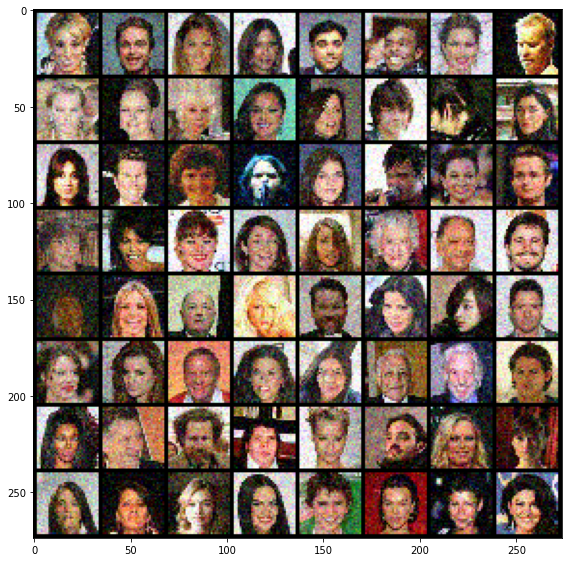

In [19]:
x, y = next(iter(train_loader))
noiser = AddGaussianNoise(std=0.1, device='cpu')

grid_img = torchvision.utils.make_grid(noiser((x + 1)/2), ncol=5)
plt.figure(figsize=(8, 10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.tight_layout()
# plt.imshow(x[0, :, 20:-20, :].cpu().numpy().transpose(1, 2, 0))

# Training the Net

In [ ]:
lr = 1e-3
epochs = 1
std = 0.1
input_size = 64

model = mobilenetv3(input_size=input_size, num_classes=10, in_channels=3, drop_prob=0.0,
                weights_dict=None, progress=True, device=device).to(device)
noiser = AddGaussianNoise(std=std, device=device)

criterion = nn.MSELoss()
optimizer = t.optim.Adam(model.parameters(), lr=lr) 

train_loss = []
val_loss = []

for epoch in range(epochs):
    start_time = time.time()
    model.train()   
    correct = 0
    train_total = 0
    train_tot_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        x_noised = noiser(x)
        output = model(x_noised)
        optimizer.zero_grad()
        loss = criterion(output, x)
        loss.backward()
        optimizer.step()

    
    # train evaluation:
    model.eval()
    correct = 0
    train_total = 0
    train_tot_loss = 0
    with t.no_grad():
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            x_noised = noiser(x)
            output = model(x_noised)
            loss = criterion(output, x) 
            train_tot_loss += loss.item()
            train_total += len(y)
        train_loss.append(train_tot_loss/len(train_loader))

    
    # validation evaluation:
    model.eval()
    correct = 0
    val_total = 0
    val_tot_loss = 0
    with t.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            x_noised = noiser(x)
            output = model(x_noised)
            loss = criterion(output, x) 
            val_tot_loss += loss.item()
            val_total += len(y)
        val_loss.append(val_tot_loss/len(val_loader))

    end_time = time.time()
    print('[Epoch {}/{}] -> Train Loss: {:.3f}, Validation Loss: {:.3f}, Time: {:.3f}'.format(
        epoch + 1, E_epochs, train_loss[-1], val_loss[-1], end_time - start_time))


# Plots

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax[0].plot(range(1, epochs + 1), train_loss, label='Train')
ax[0].plot(range(1, epochs + 1), val_loss, label='Validation')
ax[0].set_title('Training L2 Loss', fontsize=18)
ax[0].set_xlabel('Epoch', fontsize=18)
ax[0].set_ylabel('Loss', fontsize=18)
ax[0].grid()
ax[0].legend(fontsize=18)

fig.tight_layout()
fig.savefig("convergence.png")

In [ ]:
x, y = next(iter(train_loader))
noiser = AddGaussianNoise(std=0.1, device='cpu')
x_noised = noiser(x)
out = model(x_noised.to(device)).cpu()

all_images_modes = torch.cat([torch.stack([x[idx], x_noised[idx], out[idx]]) for idx in range(len(x))], dim=0)
grid = torchvision.utils.make_grid((all_images_modes - torch.min(all_images_modes))/(torch.max(all_images_modes) - torch.min(all_images_modes)), nrow=9)
plt.figure(figsize=(30, 30))
plt.imshow(grid.permute(1, 2, 0))
plt.savefig('output_grid.png')
plt.tight_layout()


# Save Net dicts

In [ ]:
output_dict = {
    "epochs": epochs,
    "lr": lr, 
    "batch_size": batch_size,
    "std": std,
    "input_size": input_size
    "train_loss": train_loss, 
    "val_loss": val_loss, 
    "net_dict": model.state_dict()
}

with open('output_dict.pickle', 'wb') as handle:
    pickle.dump(output_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
 

# Use Pre-trained Nets

In [ ]:
# with open('output_dict.pickle', 'rb') as handle:
#     output_dict = pickle.load(handle)

# model = mobilenetv3(input_size=input_size, num_classes=10, in_channels=3, drop_prob=0.0,
#             weights_dict=output_dict['net_dict'], progress=True, device=device).to(device)